In [1]:
import importlib
import Universial_Data_Functions
import Correlation_Matrix
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sktime.forecasting.compose import ForecastingPipeline, make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.datasets import load_longley
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import LSTM, Dense

#Reload the libary
if Universial_Data_Functions.Connection_With_DB: 
    data_obj = Universial_Data_Functions.Visualaize_Data(sql_handler= Universial_Data_Functions.cursor,timestamp_begin='\'2024-01-10\'',database_name='822Raw',minutes_amount = 2000000)

    to_get = [
            'AC[2].AH[1].AR[1].ART[1].IV_PV_SCL',
            'AC[2].AH[1].AM[1].ATT[1].IV_PV_SCL',
            'AC[2].AH[1].AS[1].ART[1].IV_PV_SCL',
            'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',
            'AC[2].AH[1].AI[1].ATT[1].IV_PV_SCL',
            'AC[2].AH[1].AR[1].ATT[1].IV_PV_SCL',    
            'AC[2].AH[1].AH[1].SHU[1].IV_PV',
            'AC[2].AH[1].AC[1].WCV[1].IV_PV',
            'AC[2].AH[1].AP[1].AHE[1].IV_PV',
            'AC[2].AH[1].AC[1].WTT[1].IV_PV_SCL',        
            'AC[2].AH[1].AC[1].WTT[2].IV_PV_SCL',        
            'AC[2].AH[1].FM[1].FSC[1].IV_PV_SPD'
        ]
    #Dictionary for converting tags to a more readable format
    custom = {
        'AC[2].AH[1].AC[1].WCV[1].IV_PV' : 'Cold water valve (%)',
        'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL' : 'Supply air temperature (°C)',
        'AC[2].AH[1].AM[1].ATT[1].IV_PV_SCL' : 'Mixing air temperature (°C)',
        'AC[2].AH[1].FM[1].FSC[1].IV_PV_SPD' : 'Supply fan speed (%)',
        'AC[2].AH[1].AI[1].ATT[1].IV_PV_SCL' : 'Intake air temperature (°C)',
        'AC[2].AH[1].AC[1].WTT[1].IV_PV_SCL' : 'Cold water inlet temeprature (°C)',
        'AC[2].AH[1].AC[1].WTT[2].IV_PV_SCL' : 'Cold water outlet temeprature (°C)',
        'AC[2].AH[1].AR[1].ART[1].IV_PV_SCL' : 'Return air humidity (%)',
        'AC[2].AH[1].AH[1].SHU[1].IV_PV':  'Steam humidifier output (%) ',
        'AC[2].AH[1].AS[1].ART[1].IV_PV_SCL': 'Supply air humidity (%)'
    }

    #Create the unfliterd data frame
    data_obj.Create_DF(requests=to_get,fill_zero_room= True,fill_zero_other= True,AH_in_table= False)
    #Mask off broken sensor data
    data_obj.mask_off('AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',value= 0, minutes= 2)
    #Clear the gaps that are present in the dataframe
    data_obj.shorten_all_gaps(steps = 20,reset_index= True)
    
print(data_obj.df.head())


2025-03-08 16:31:02.490138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741451462.658204    4804 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741451462.701781    4804 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-08 16:31:03.116285: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/Digital_Twin/Finished/Universial_Data_Functions.py:328: FutureWarning: Downcasting object dtype arrays on .fillna, .ffi

Frame empty!!!!
   AC[2].AH[1].AR[1].ART[1].IV_PV_SCL  AC[2].AH[1].AS[1].ART[1].IV_PV_SCL  \
0                                45.0                                47.0   
1                                45.0                                52.0   
2                                45.0                                52.0   
3                                45.0                                45.0   
4                                45.0                                52.0   

   AC[2].AH[1].AH[1].SHU[1].IV_PV  AC[2].AH[1].AM[1].ATT[1].IV_PV_SCL  \
0                            77.0                                11.6   
1                            77.0                                11.7   
2                            77.0                                11.6   
3                            77.0                                11.6   
4                            77.0                                11.6   

   AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL  AC[2].AH[1].AI[1].ATT[1].IV_PV_SCL  \
0    

/home/Digital_Twin/Finished/Universial_Data_Functions.py:628: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data_range = pd.date_range(start= start,periods= len(df_pointer), freq= 'T')


In [7]:
from sklearn.preprocessing import MinMaxScaler
#Noralise the train data X
scaler = MinMaxScaler()
def normalize_with_DT(df):
    #Split the dataframe in datetime columns and numerical columns
    datetime_cols = df.select_dtypes(include=['datetime64']).columns
    numerical_cols = df.select_dtypes(include=['float64','int64']).columns
    #apply the scaler to the numerical columns
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    #Return the combined and transformed dataframe 
    return pd.concat([ df[numerical_cols]], axis=1)

In [8]:
#For the scaler get the lowest and the highest lowest values
lower_range_valve, upper_range_valve = data_obj.retun_min_max(column= 'AC[2].AH[1].AC[1].WCV[1].IV_PV',df_External= data_obj.df)
lower_range_temp, upper_range_temp = data_obj.retun_min_max(column= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',df_External= data_obj.df)
#Drop the timestamp from the dataframes
lower_range_valve.drop('Timestamp',axis= 1,inplace= True)
upper_range_valve.drop('Timestamp',axis= 1,inplace= True)

#Drop the supply temeprature
lower_range_valve.drop('AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',axis= 1,inplace= True)
upper_range_valve.drop('AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',axis= 1,inplace= True)

#This is a function that converts the data within the dataframe range
def normalize_scale(min,max,input):
    if input >= min and input <= max:
        result = (input-min) / (max-min)
        return result
    elif input < min:
        return 0
    else:
        return 1
low_temp = lower_range_temp['AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL'].values[0]
high_temp = upper_range_temp['AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL'].values[0]

#This is a function that converts the data within the dataframe range
def normalize_scale(min,max,input):
    if input >= min and input <= max:
        result = (input-min) / (max-min)
        return result
    elif input < min:
        return 0
    else:
        return 1

print(low_temp)
Temp_diff = normalize_scale(min = low_temp, max= high_temp , input = 11.2)
print(Temp_diff)

10.200000000000001
0.08196721311475394


In [ ]:
#Convert the timestamp to a dat time varaible 
data_obj.df['Timestamp'] = pd.to_datetime(data_obj.df['Timestamp'])
timestamp = data_obj.df['Timestamp']
# Extract the hour of day and replace the 'Timestamp' column
y = data_obj.df[['AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL', 'Timestamp']]
#Create a train and test set for the Y (supply air temperature )
train_y, test_y =train_test_split(y, test_size=0.2,train_size= 0.8, shuffle= False)
train_y.drop(['Timestamp'],axis = 1, inplace= True)
test_y_2 =  test_y.copy()
test_y.drop(['Timestamp'],axis = 1,inplace= True)
test_y.reset_index(drop= True,inplace= True)

data_obj.df['Timestamp'] = pd.to_datetime(data_obj.df['Timestamp'])

#Normalize the whole dataframe and make a split between the train and the test set
inter_df = normalize_with_DT(data_obj.df)
train, test = train_test_split(inter_df, test_size=0.2,train_size= 0.8, shuffle= False)
test.reset_index(drop= True,inplace= True)
#Replace the scaled Y for the non scaled Y
train.drop('AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',axis= 1,inplace= True)
train =pd.concat([train,train_y],axis = 1)
print(train_y.head())

   AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL
0                                18.2
1                                18.2
2                                18.2
3                                18.2
4                                18.2


In [10]:
#Create a object with datapoints
Data_change = []
Data_To_Alter = []
Data_To_Alter.append(Universial_Data_Functions.Data_Add(column= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL', add= 2.0))
Data_To_Alter.append(Universial_Data_Functions.Data_Add(column= 'AC[2].AH[1].AC[1].WCV[1].IV_PV', add= -0.2))
Data_change.append(Data_To_Alter)

Data_To_Alter = []
Data_To_Alter.append(Universial_Data_Functions.Data_Add(column= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL', add= -2.0))
Data_To_Alter.append(Universial_Data_Functions.Data_Add(column= 'AC[2].AH[1].AC[1].WCV[1].IV_PV', add= 0.2))
Data_change.append(Data_To_Alter)

Data_To_Alter = []
Data_To_Alter.append(Universial_Data_Functions.Data_Add(column= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL', add= 4))
Data_To_Alter.append(Universial_Data_Functions.Data_Add(column= 'AC[2].AH[1].AC[1].WCV[1].IV_PV', add= -0.4))
Data_change.append(Data_To_Alter)

Data_To_Alter = []
Data_To_Alter.append(Universial_Data_Functions.Data_Add(column= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL', add= -4))
Data_To_Alter.append(Universial_Data_Functions.Data_Add(column= 'AC[2].AH[1].AC[1].WCV[1].IV_PV', add= 0.4))
Data_change.append(Data_To_Alter)

#Put on False when the normal regression model is trained, and when it it set on True the regression model with the added data is trained
extend = True
if extend == True: 
    train = data_obj.extend_df(start = 0,length= 70000,to_change=Data_change,interpolate_steps= 30,timestamp_begin= '\'2024-01-05\'',df_external=train,df_copy=train,pyramid=True,gaussian= True)



/home/Digital_Twin/Finished/Universial_Data_Functions.py:628: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data_range = pd.date_range(start= start,periods= len(df_pointer), freq= 'T')


In [ ]:
#Create the translation dictinaray from the tags to a more readable text
custom = {
    'AC[2].AH[1].AC[1].WCV[1].IV_PV' : 'Cold water valve (%)',
    'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL' : 'Supply air temperature (°C)',
    'AC[2].AH[1].AM[1].ATT[1].IV_PV_SCL' : 'Mixing air temperature (°C)',
    'AC[2].AH[1].FM[1].FSC[1].IV_PV_SPD' : 'Supply fan speed (%)',
    'AC[2].AH[1].AI[1].ATT[1].IV_PV_SCL' : 'Intake air temperature (°C)',
    'AC[2].AH[1].AC[1].WTT[1].IV_PV_SCL' : 'Cold water inlet temeprature (°C)',
    'AC[2].AH[1].AC[1].WTT[2].IV_PV_SCL' : 'Cold water outlet temeprature (°C)',
    'AC[2].AH[1].AR[1].ART[1].IV_PV_SCL' : 'Return air humidity (%)',
    'AC[2].AH[1].AH[1].SHU[1].IV_PV':  'Steam humidifier output (%) ',
    'AC[2].AH[1].AS[1].ART[1].IV_PV_SCL': 'Supply air humidity (%)', 
    'AC[2].AH[1].AR[1].ATT[1].IV_PV_SCL': 'Return air temperature (°C)',
    'AC[2].AH[1].AP[1].AHE[1].IV_PV': 'Preheater output (%)'
}

In [12]:
#Drop the timestamp from the training set
train.drop(['Timestamp'],axis = 1, inplace= True)

In [13]:
#Drop the supply air temperature from the test set (y)
test_x = test.drop('AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',axis= 1)
#Create the test sets with the lowerd and the upperd cold water valve positions
test_x_Lowered = test_x.copy()
test_x_Upperd = test_x.copy()
test_x_Lowered['AC[2].AH[1].AC[1].WCV[1].IV_PV'] = test_x_Lowered['AC[2].AH[1].AC[1].WCV[1].IV_PV'].apply(lambda x: max(x - 0.3, -1))
test_x_Upperd['AC[2].AH[1].AC[1].WCV[1].IV_PV'] = test_x_Upperd['AC[2].AH[1].AC[1].WCV[1].IV_PV'].apply(lambda x: min(x + 0.3, 1))
test_Com =pd.concat([test_x,test_y],axis = 1)
test_Com_l =pd.concat([test_x_Lowered,test_y],axis = 1)
test_Com_u =pd.concat([test_x_Upperd,test_y],axis = 1)
#Noralise the train data X

print(test_y.head())

   AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL
0                                13.4
1                                13.4
2                                13.3
3                                13.4
4                                13.4


In [14]:
#Create a sliding window of the regression model
def create_sliding_window(df, target_col, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        window = df.iloc[i:i + window_size].drop(columns=[target_col]).values.flatten()
        X.append(window)
        y.append(df.iloc[i + window_size][target_col])
    return np.array(X), np.array(y)
#Create all the sliding windows (1 training and 3 testing sets)
window_train_X, window_train_Y = create_sliding_window(df = train, target_col= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',window_size= 120)
window_test_X, window_test_Y_np = create_sliding_window(df = test_Com, target_col= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',window_size= 120)
window_test_X_l, window_test_Y_np_s = create_sliding_window(df = test_Com_l, target_col= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',window_size= 120)
window_test_X_u, window_test_Y_np_d = create_sliding_window(df = test_Com_u, target_col= 'AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL',window_size= 120)
window_test_Y = pd.DataFrame(window_test_Y_np, columns=['AC[2].AH[1].AS[1].ATT[1].IV_PV_SCL'])

In [15]:
#Train the regression model
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import root_mean_squared_error
regr = LinearRegression()   
regr.fit(window_train_X, window_train_Y)


LinearRegression()

In [21]:
test_y_plot = pd.concat([window_test_Y,timestamp],axis= 1)

In [17]:
#Mak predictions with the regression model
import matplotlib.pyplot as plt 
test_y.reset_index(drop= True,inplace= True)
data_obj.lower_range = 0
data_obj.upper_range = 30
y_pred = regr.predict(window_test_X) 
y_pred_l = regr.predict(window_test_X_l)
y_pred_u = regr.predict(window_test_X_u)




In [18]:
test_y_2.reset_index(drop= True,inplace= True)

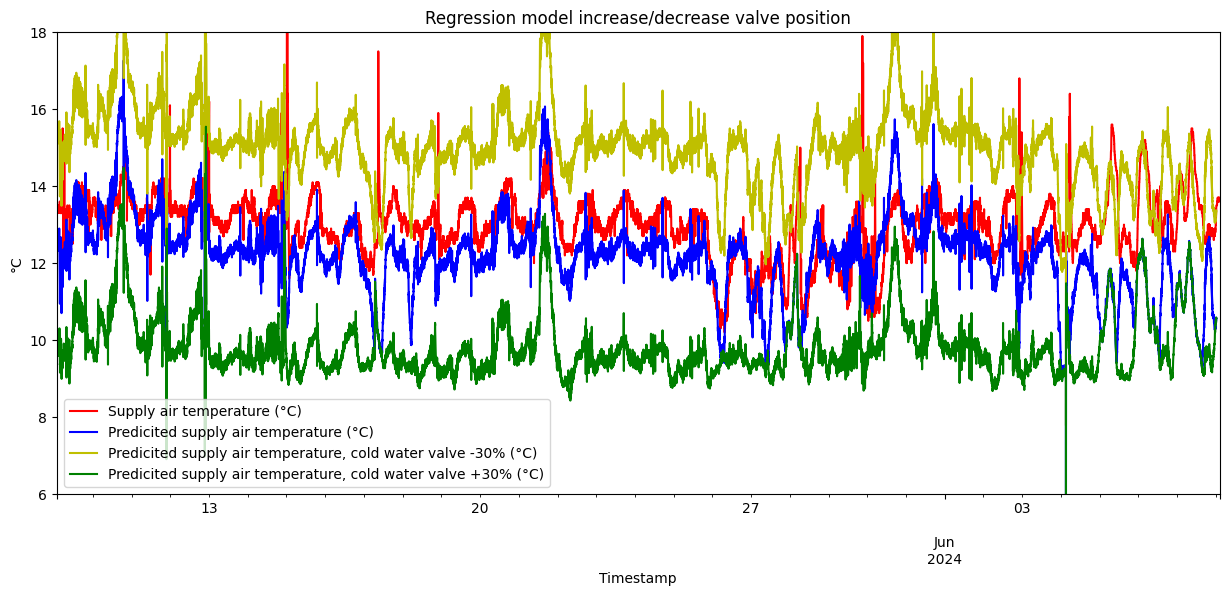

<Figure size 20000x600 with 0 Axes>

<Figure size 1500x8000 with 0 Axes>

In [19]:
#Plot the predictions
data_obj.lower_range = 6
data_obj.upper_range = 18
y_preddf = pd.DataFrame(y_pred,columns=['Predicited supply air temperature (°C)'])
y_preddf_Less = pd.DataFrame(y_pred_l,columns=['Predicited supply air temperature, cold water valve -30% (°C)'])
y_preddf_More = pd.DataFrame(y_pred_u,columns=['Predicited supply air temperature, cold water valve +30% (°C)'])
data_obj.amount_of_Plots = 1 
df_result = pd.concat([test_y_2,y_preddf,y_preddf_Less,y_preddf_More],axis = 1)
data_obj.Plot_Custom(df_in=df_result,title='Regression model increase/decrease valve position',custom_names=custom,light_mode=True,legend_heigth= -0.2,y_title_1= '°C')

In [ ]:
#Get the RMSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(window_test_Y_np, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 1.2660014162717157
